Import the library

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

检查分类列并转换为 category（如 `store_type`, `item_family`）

In [6]:
# 加载数据
DATA_DIR = (Path.cwd().parent / "data").resolve()   # …/Store-Sales---Time-Series-Forecasting/data
print("DATA_DIR =", DATA_DIR) # 返回数据目录路径
train_df  = pd.read_csv(DATA_DIR / "train.csv")
stores_df = pd.read_csv(DATA_DIR / "stores.csv")

# 检查列名
print("Train columns:", train_df.columns.tolist())
print("Stores columns:", stores_df.columns.tolist())

# 想要转为 category 类型的列
cat_cols_train = ['family']                # 商品类别
cat_cols_stores = ['type', 'city', 'state', 'cluster']  # 门店相关列

# train 中的 family
for col in cat_cols_train:
    if col in train_df.columns:
        train_df[col] = train_df[col].astype('category')

# stores 中的类别列
for col in cat_cols_stores:
    if col in stores_df.columns:
        stores_df[col] = stores_df[col].astype('category')

# 验证类型
print("\ntrain_df info:")
print(train_df.info())

print("\nstores_df info:")
print(stores_df.info())

DATA_DIR = /Volumes/ZHITAI TiPlus7100 1TB/编程文件/py/kaggle/sotre-times/Store-Sales---Time-Series-Forecasting/data
Train columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']
Stores columns: ['store_nbr', 'city', 'state', 'type', 'cluster']

train_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype   
---  ------       -----   
 0   id           int64   
 1   date         object  
 2   store_nbr    int64   
 3   family       category
 4   sales        float64 
 5   onpromotion  int64   
dtypes: category(1), float64(1), int64(3), object(1)
memory usage: 117.3+ MB
None

stores_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   store_nbr  54 non-null     int64   
 1   city       54 non-null     category
 2   state      54 non-null     cate

生成交叉特征 store_type × item_family

In [7]:
# store_type 在 stores.csv，item_family 在 train.csv

# 通过 store_nbr 这个共同的键，合并两个数据集（train_df 和 stores_df）
train_merged = train_df.merge(stores_df[['store_nbr', 'type']], on='store_nbr', how='left')

# 创建交叉特征列
train_merged['store_type_item_family'] = (
    train_merged['type'].astype(str) + "_" + train_merged['family'].astype(str)
)

# 结果
print(train_merged[['type', 'family', 'store_type_item_family']].head())

  type      family store_type_item_family
0    D  AUTOMOTIVE           D_AUTOMOTIVE
1    D   BABY CARE            D_BABY CARE
2    D      BEAUTY               D_BEAUTY
3    D   BEVERAGES            D_BEVERAGES
4    D       BOOKS                D_BOOKS


标记连续促销天数（基于 `is_promo` 列）

In [8]:
def mark_promo_streak(group: pd.DataFrame) -> pd.Series:
    """计算每个 (store_nbr, family) 的连续促销天数"""
    streak = pd.Series(0, index=group.index)
    current = 0
    for i in range(len(group)):
        if group.loc[group.index[i], "onpromotion"]:
            current += 1
        else:
            current = 0
        streak.iloc[i] = current
    return streak

# === 应用到每个门店-商品组合 ===
train_df = train_df.sort_values(["store_nbr", "family", "date"])
train_df["promo_streak"] = (
    train_df.groupby(["store_nbr", "family"], group_keys=False)
            .apply(mark_promo_streak)
)

# === 结果预览 ===
print("\n=== 连续促销天数示例 ===")
print(train_df[["store_nbr", "family", "date", "onpromotion", "promo_streak"]].head(10))

# === 一些统计信息 ===
print("\n=== 促销统计 ===")
print(f"最长连续促销天数: {train_df['promo_streak'].max()}")
print("\n促销持续天数分布:")
print(train_df.loc[train_df["promo_streak"] > 0, "promo_streak"]
      .value_counts()
      .sort_index()
      .head())

/var/folders/sy/jcsbw26j6pbfklmwt9ky3zjw0000gn/T/ipykernel_49792/932373681.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(["store_nbr", "family"], group_keys=False)



=== 连续促销天数示例 ===
       store_nbr      family        date  onpromotion  promo_streak
0              1  AUTOMOTIVE  2013-01-01            0             0
1782           1  AUTOMOTIVE  2013-01-02            0             0
3564           1  AUTOMOTIVE  2013-01-03            0             0
5346           1  AUTOMOTIVE  2013-01-04            0             0
7128           1  AUTOMOTIVE  2013-01-05            0             0
8910           1  AUTOMOTIVE  2013-01-06            0             0
10692          1  AUTOMOTIVE  2013-01-07            0             0
12474          1  AUTOMOTIVE  2013-01-08            0             0
14256          1  AUTOMOTIVE  2013-01-09            0             0
16038          1  AUTOMOTIVE  2013-01-10            0             0

=== 促销统计 ===
最长连续促销天数: 363

促销持续天数分布:
promo_streak
1    127936
2     47470
3     29790
4     21968
5     17511
Name: count, dtype: int64


/var/folders/sy/jcsbw26j6pbfklmwt9ky3zjw0000gn/T/ipykernel_49792/932373681.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(mark_promo_streak)


总销售量随时间变化折线图

/var/folders/sy/jcsbw26j6pbfklmwt9ky3zjw0000gn/T/ipykernel_49792/218394143.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(["date", "family"])["sales"]


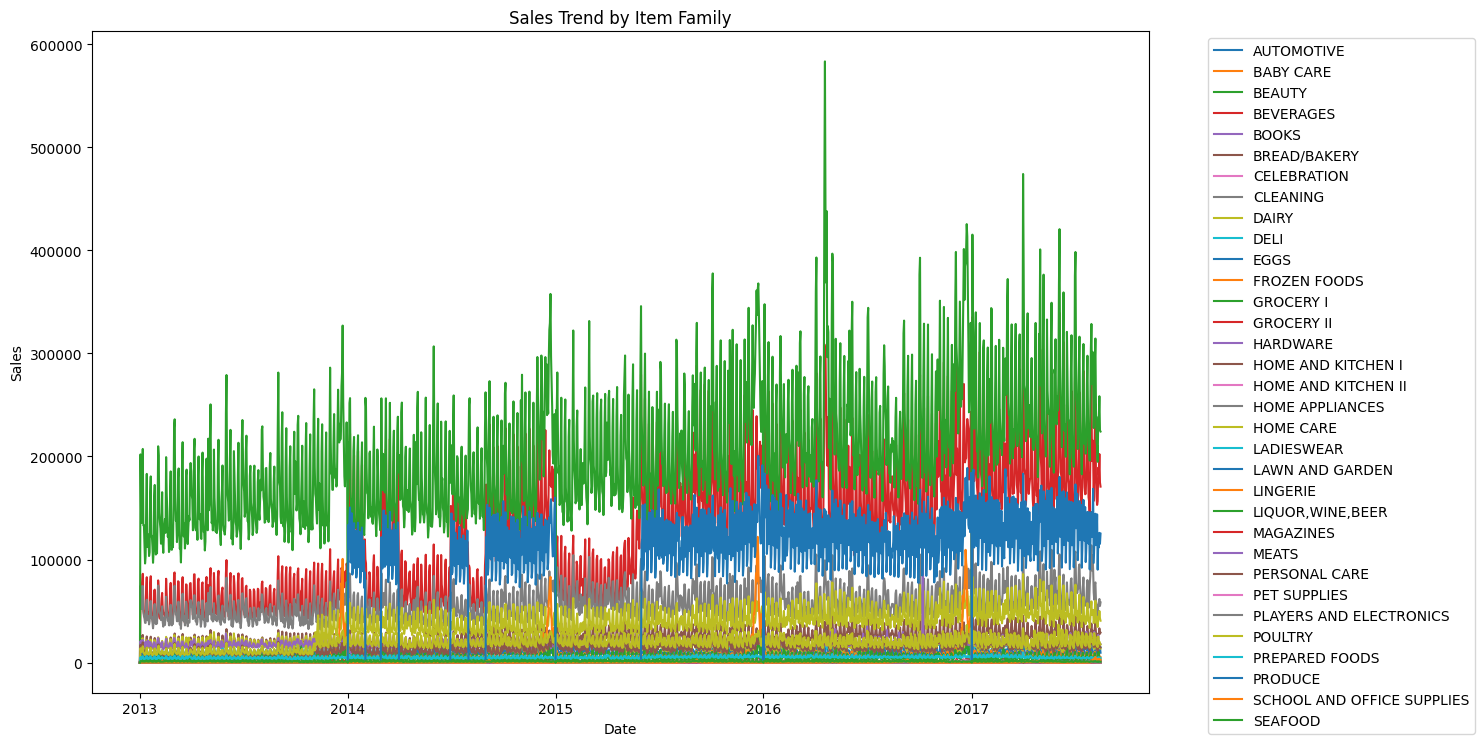

<Figure size 640x480 with 0 Axes>

In [10]:
train_df["date"] = pd.to_datetime(train_df["date"])

df_family = (
    train_df.groupby(["date", "family"])["sales"]
            .sum()
            .reset_index()
)

plt.figure(figsize=(15, 8))

for fam in df_family["family"].unique():
    sub = df_family[df_family["family"] == fam]
    plt.plot(sub["date"], sub["sales"], label=fam)

plt.title("Sales Trend by Item Family")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

plt.savefig("../figures/item_family_sales.jpg", dpi=300, bbox_inches="tight")

节假日销售对比图（`holidays_events.csv`）

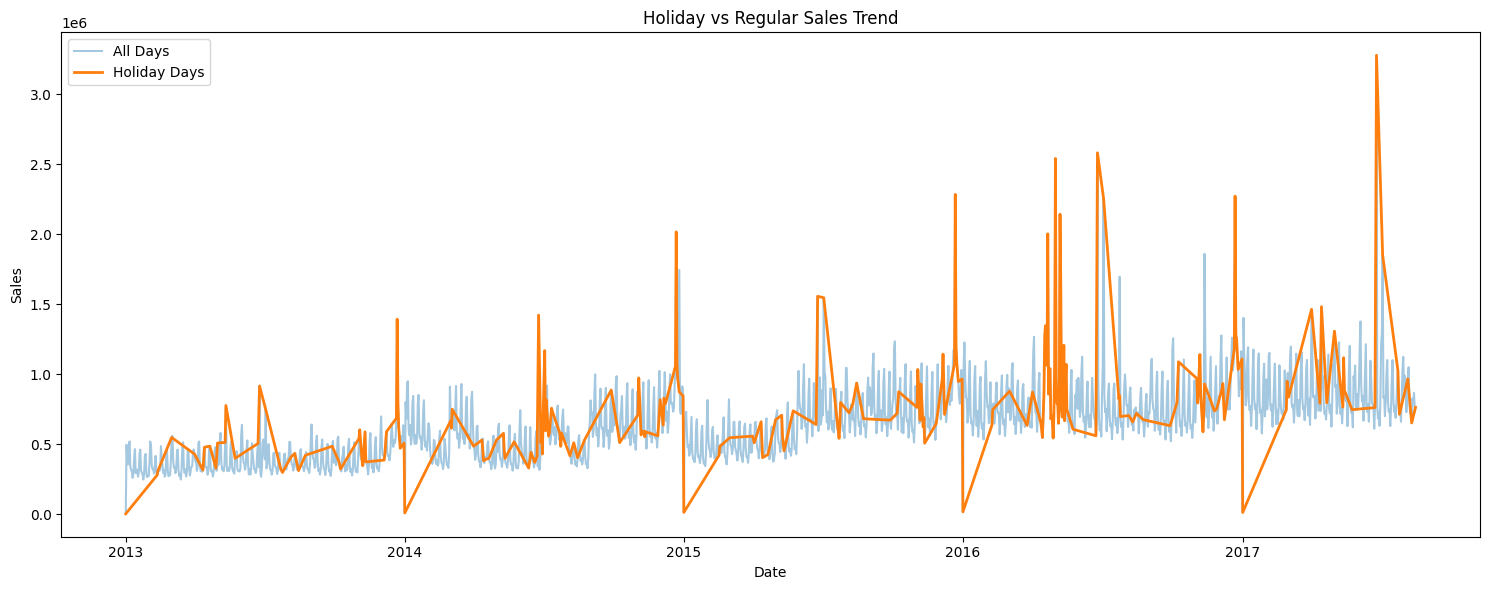

<Figure size 640x480 with 0 Axes>

In [11]:
holidays_df = pd.read_csv(DATA_DIR / "holidays_events.csv")
holidays_df["date"] = pd.to_datetime(holidays_df["date"])
train_df["date"] = pd.to_datetime(train_df["date"])

df = train_df.merge(
    holidays_df[["date", "type", "locale", "description"]],
    on="date",
    how="left"
)

holiday_types = ["Holiday", "Event", "Additional"]
df_holiday = df[df["type"].isin(holiday_types)]

daily_sales = df.groupby("date")["sales"].sum().reset_index()

holiday_sales = (
    df_holiday.groupby("date")["sales"].sum().reset_index()
)

plt.figure(figsize=(15, 6))

plt.plot(daily_sales["date"], daily_sales["sales"],
         label="All Days", alpha=0.4)

plt.plot(holiday_sales["date"], holiday_sales["sales"],
         label="Holiday Days", linewidth=2)

plt.title("Holiday vs Regular Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

plt.savefig("../figures/holiday_vs_regular_sales.jpg", dpi=300, bbox_inches="tight")


交易量与销售量热力图

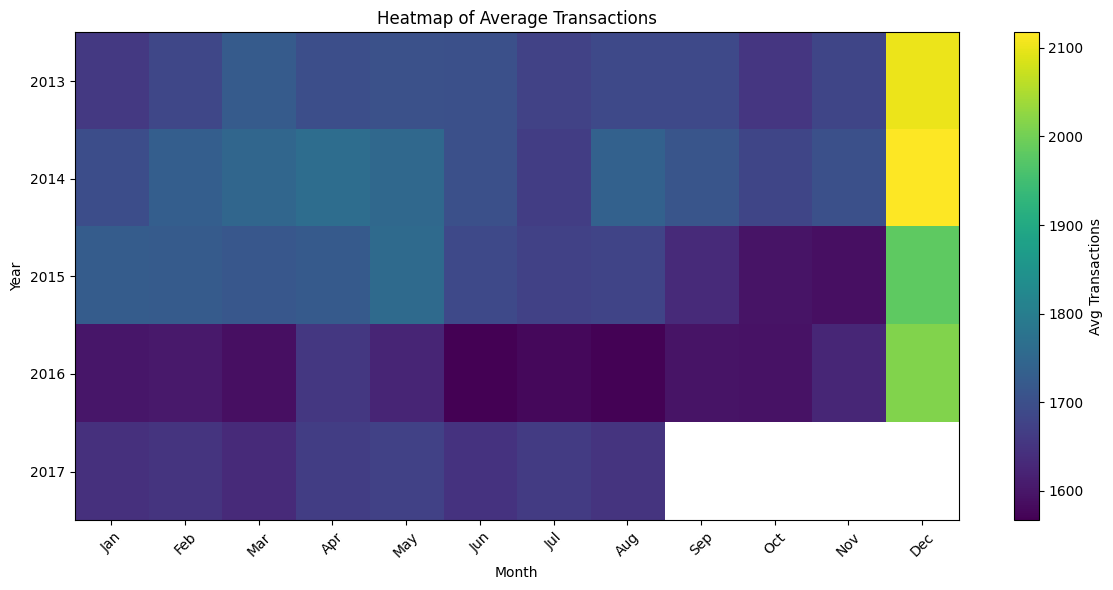

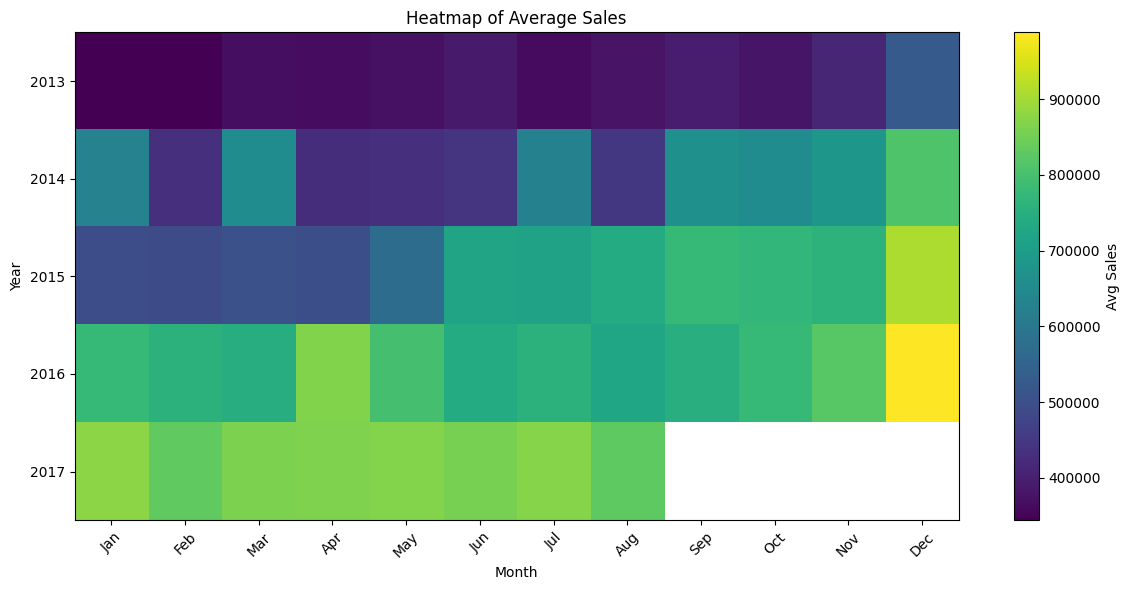

In [13]:
transactions_df = pd.read_csv(DATA_DIR / "transactions.csv")
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
train_df["date"] = pd.to_datetime(train_df["date"])

sales_daily = (
    train_df.groupby("date")["sales"]
            .sum()
            .reset_index()
)

df_ts = sales_daily.merge(transactions_df, on="date", how="left")

df_ts["year"] = df_ts["date"].dt.year
df_ts["month"] = df_ts["date"].dt.month

pivot_trans = df_ts.pivot_table(
    index="year", columns="month",
    values="transactions", aggfunc="mean"
)

pivot_sales = df_ts.pivot_table(
    index="year", columns="month",
    values="sales", aggfunc="mean"
)

def plot_heatmap(pivot_df, title, label, filename):
    plt.figure(figsize=(12, 6))
    data = pivot_df.values
    im = plt.imshow(data, cmap="viridis", aspect="auto")
    cbar = plt.colorbar(im)
    cbar.set_label(label)

    plt.xticks(
        np.arange(12),
        ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
        rotation=45
    )
    plt.yticks(np.arange(len(pivot_df.index)), pivot_df.index)

    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel("Year")
    plt.tight_layout()
    plt.savefig(f"../figures/{filename}", dpi=300, bbox_inches="tight")
    plt.show()

plot_heatmap(
    pivot_trans,
    "Heatmap of Average Transactions",
    "Avg Transactions",
    "transactions_heatmap.jpg"
)

plot_heatmap(
    pivot_sales,
    "Heatmap of Average Sales",
    "Avg Sales",
    "sales_heatmap.jpg"
)

油价与销售量散点图

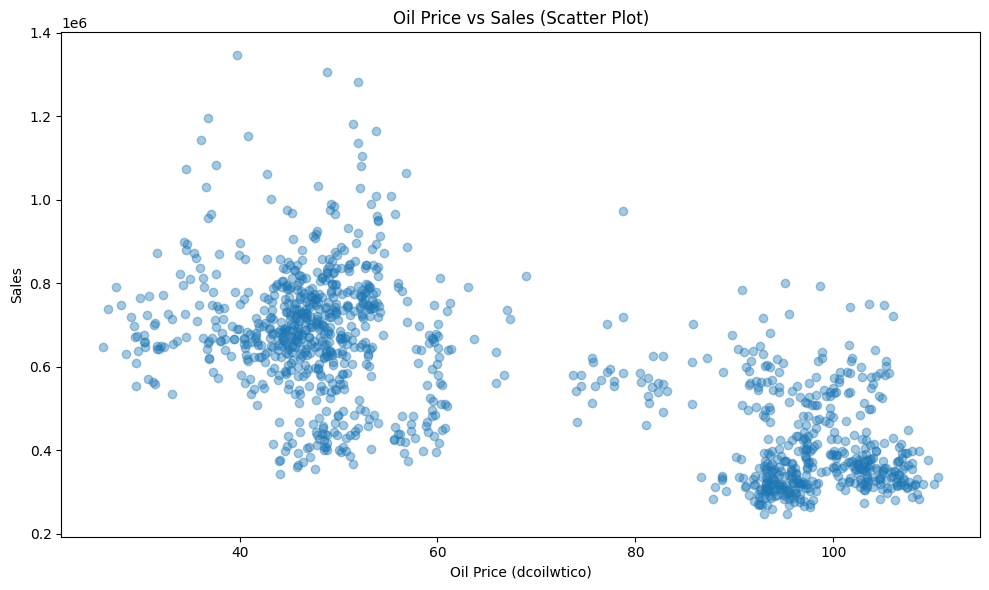

<Figure size 640x480 with 0 Axes>

In [14]:
oil_df = pd.read_csv(DATA_DIR / "oil.csv")
oil_df["date"] = pd.to_datetime(oil_df["date"])

train_df["date"] = pd.to_datetime(train_df["date"])

sales_daily = (
    train_df.groupby("date")["sales"]
            .sum()
            .reset_index()
)

df_oil = sales_daily.merge(oil_df, on="date", how="left")

plt.figure(figsize=(10, 6))

plt.scatter(df_oil["dcoilwtico"], df_oil["sales"], alpha=0.4)

plt.title("Oil Price vs Sales (Scatter Plot)")
plt.xlabel("Oil Price (dcoilwtico)")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()
plt.savefig("../figures/oil_vs_sales_scatter.jpg", dpi=300, bbox_inches="tight")